# Training the SPOCK model

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
from sklearn.model_selection import train_test_split

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

In [12]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
	
df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [13]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [14]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1249051, 21), (1249051, 11))

In [15]:
merged_df.head()

,Des'n,H_x,G,Epoch,M,Peri.,Node,Incl.,e,n,...,propa,da,prope,de,propsini,dsini,g,s,H_y,NumOpps
0,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,...,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123
1,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,...,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121
2,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,...,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114
3,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,...,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110
4,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,...,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87


In [16]:
merged_df['ecospo'] = merged_df['e']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['e']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['Incl.']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['Incl.']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [ ]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['e']
delsini = merged_df['propsini']-np.sin(merged_df['Incl.']*np.pi/180)
g = merged_df['g']
s = merged_df['s']

In [18]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)

In [19]:
trainY.shape

(999240,)

In [20]:
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [21]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [29]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.022364438273980543                                  
+/-                                                   
7.64604364387271e-05                                  
SCORE:                                                                          
0.02236242746332181                                                             
+/-                                                                             
7.59700130450827e-05                                                            
SCORE:                                                                          
0.020775978954114212                                                            
+/-                                                                             
6.616393638950302e-05                                                           
SCORE:                                                                          
0.019917093104836532                               

In [30]:
best

{'x_max_depth': 6.0,
 'x_min_child': 29.027212358902943,
 'x_subsample': 0.9458899808537233}

In [31]:
model = XGBRegressor(learning_rate = 0.05, 
                         max_depth = 6, 
                         subsample = 0.946,
                         min_child_weight = 29.03)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=500)

[0]	train-rmse:0.03226+0.00002	test-rmse:0.03226+0.00006
[1]	train-rmse:0.03123+0.00002	test-rmse:0.03123+0.00006
[2]	train-rmse:0.03026+0.00002	test-rmse:0.03026+0.00006
[3]	train-rmse:0.02935+0.00001	test-rmse:0.02936+0.00006
[4]	train-rmse:0.02850+0.00001	test-rmse:0.02851+0.00007
[5]	train-rmse:0.02771+0.00001	test-rmse:0.02772+0.00007
[6]	train-rmse:0.02698+0.00001	test-rmse:0.02699+0.00007
[7]	train-rmse:0.02629+0.00001	test-rmse:0.02630+0.00007
[8]	train-rmse:0.02565+0.00002	test-rmse:0.02566+0.00007
[9]	train-rmse:0.02505+0.00002	test-rmse:0.02506+0.00007
[10]	train-rmse:0.02449+0.00002	test-rmse:0.02451+0.00007
[11]	train-rmse:0.02397+0.00002	test-rmse:0.02399+0.00007
[12]	train-rmse:0.02348+0.00002	test-rmse:0.02350+0.00007
[13]	train-rmse:0.02303+0.00002	test-rmse:0.02305+0.00007
[14]	train-rmse:0.02261+0.00002	test-rmse:0.02264+0.00007
[15]	train-rmse:0.02222+0.00002	test-rmse:0.02225+0.00007
[16]	train-rmse:0.02186+0.00002	test-rmse:0.02189+0.00007
[17]	train-rmse:0.02153+

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

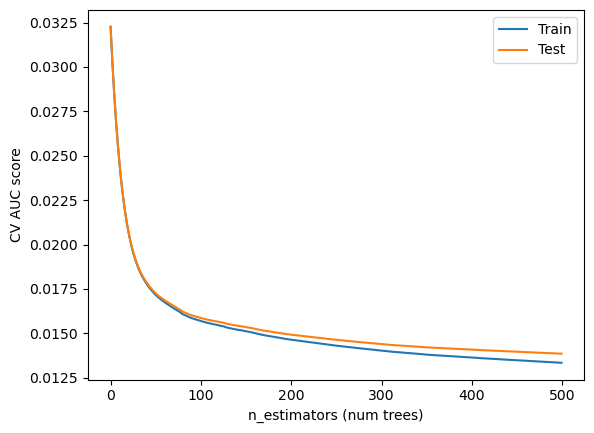

In [32]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

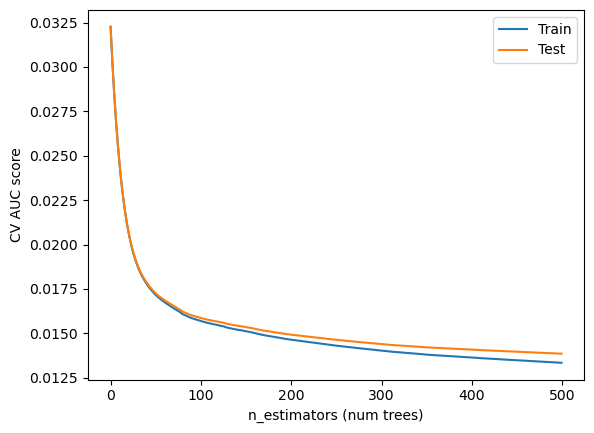

In [33]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

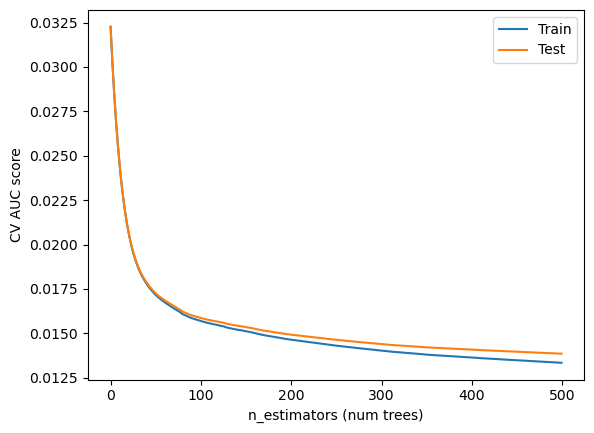

In [34]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

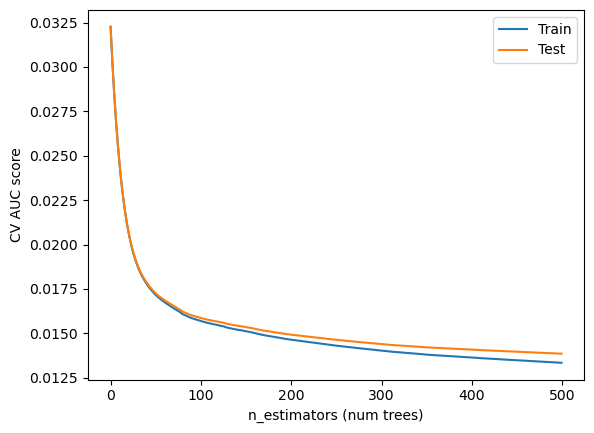

In [35]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

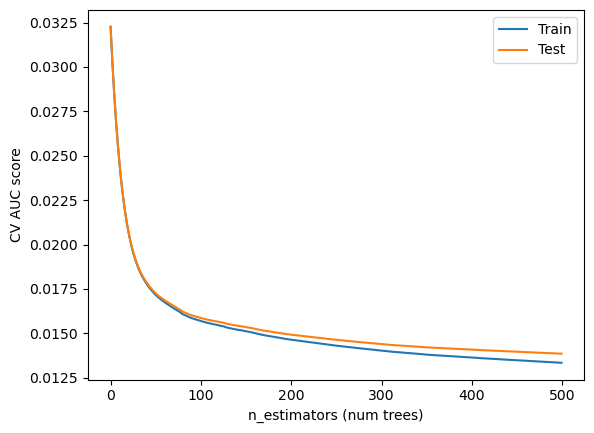

In [36]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [37]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:24:13] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [38]:
%%time
pred = model.predict(dtest)

CPU times: user 17.1 s, sys: 122 ms, total: 17.3 s
Wall time: 270 ms


In [39]:
np.std(pred-testY)

0.01333641461501545

Text(0.5, 0, 'Prop e')

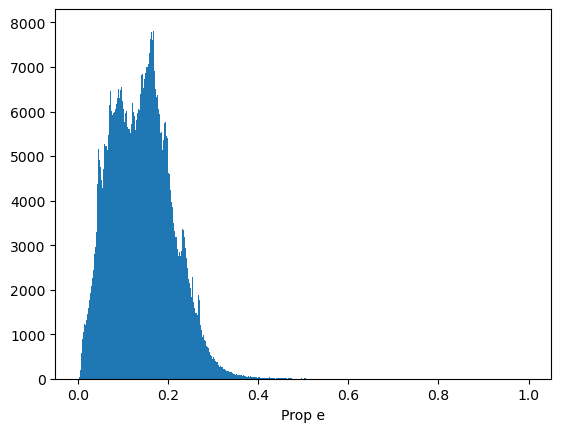

In [40]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

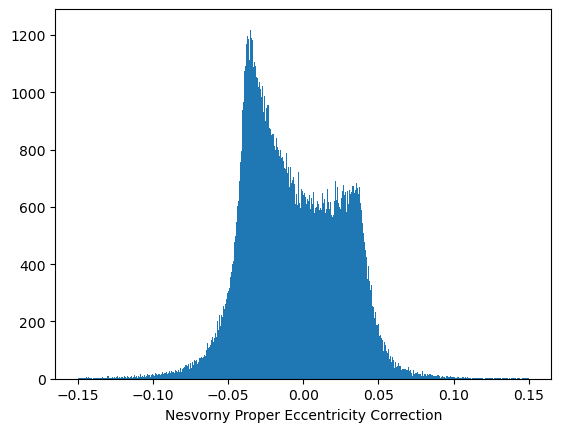

In [41]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

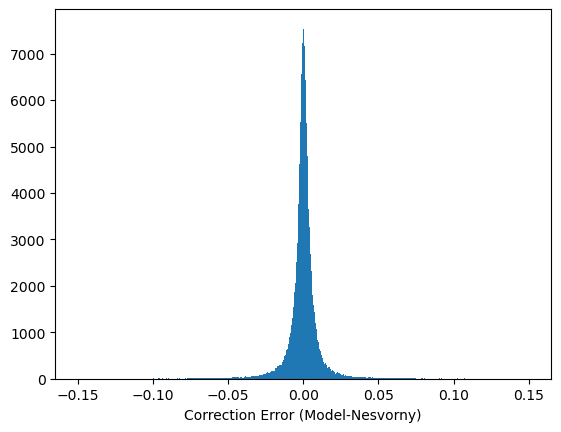

In [42]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')

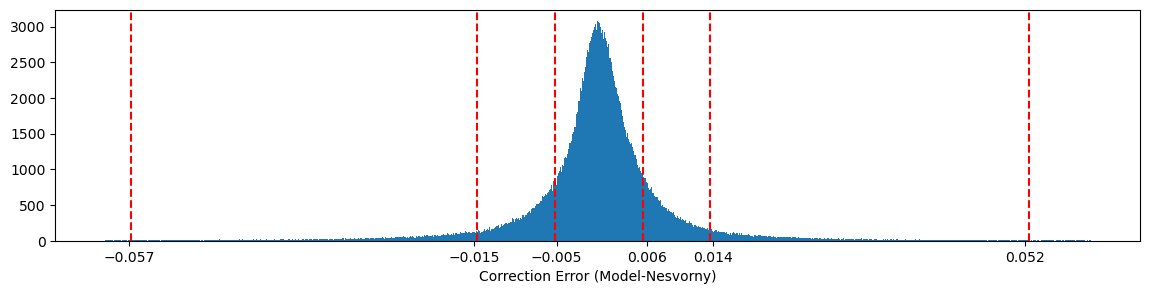

In [43]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

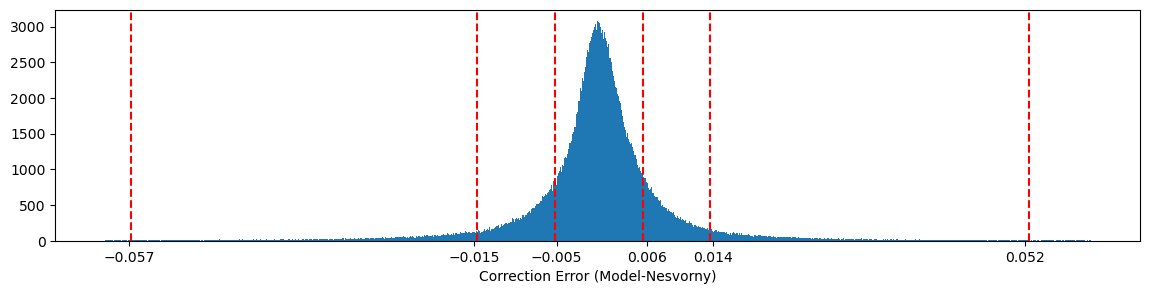

In [44]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

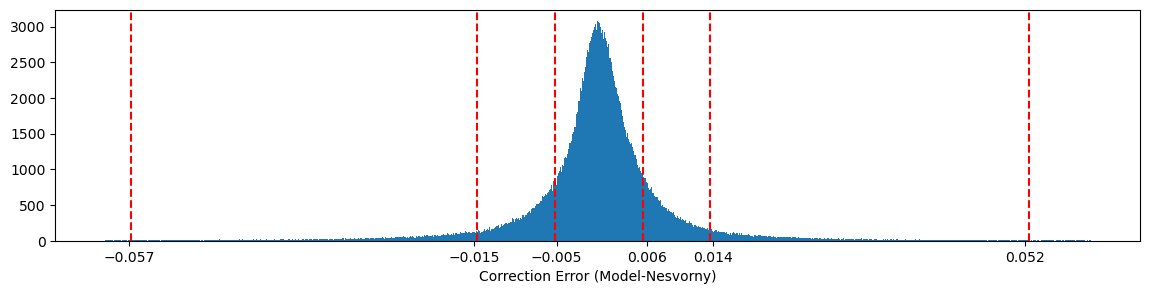

In [45]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

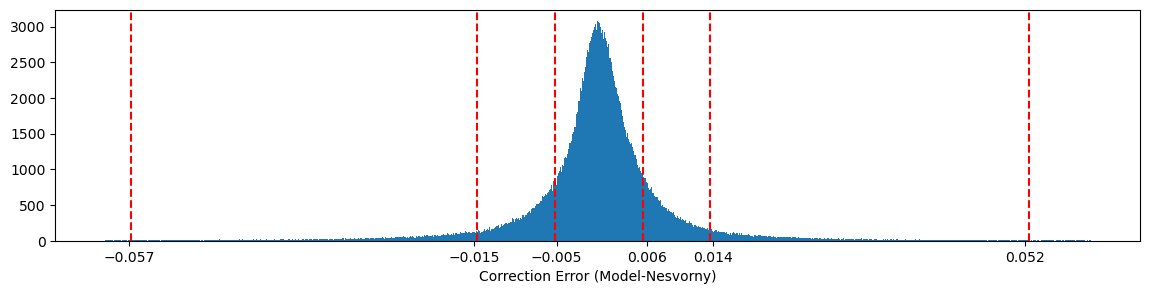

In [46]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

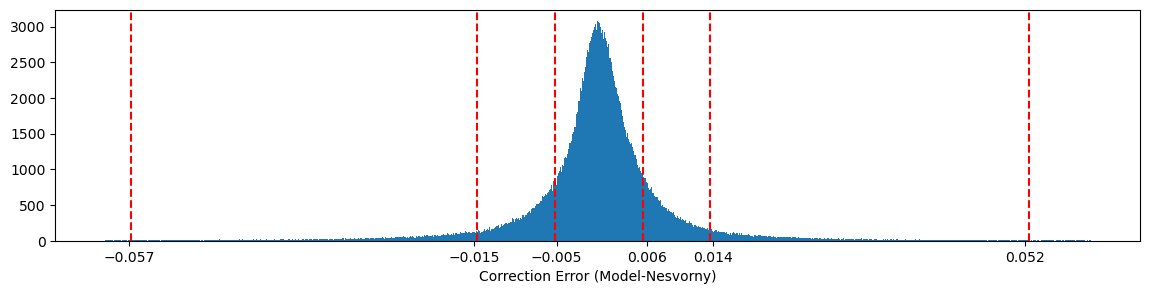

In [47]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [48]:
(pred-testY).min()

-0.4639591967136026

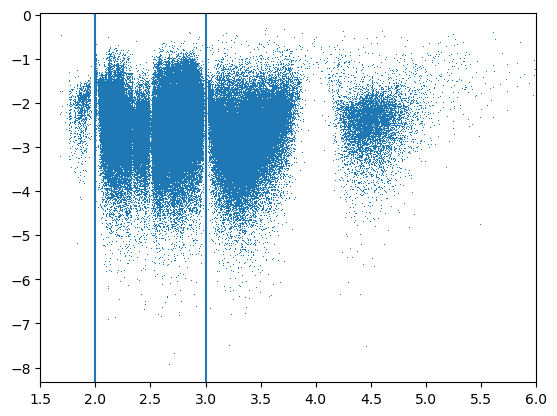

In [49]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

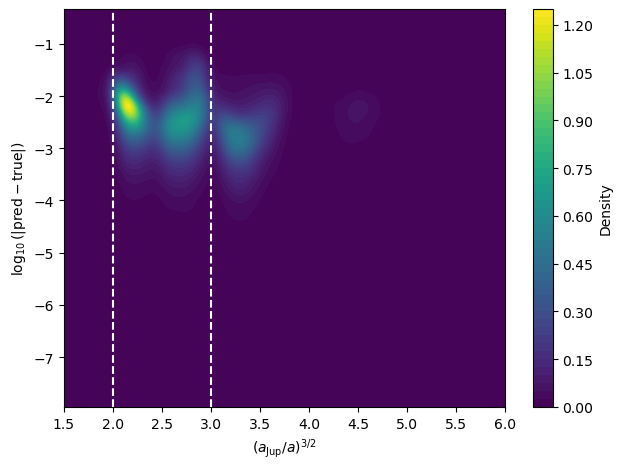

In [50]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()